In [ ]:
!pip install trino==0.327.0 prophet==1.1.5 

In [1]:
import trino

def get_connection():
    connection = trino.dbapi.connect(
        host="trino-coordinator-default.default.svc.cluster.local",
        http_scheme="https",
        verify="/stackable/secrets/trino-ca-cert/ca.crt",
        port=8443,
        user="admin",
        auth=trino.auth.BasicAuthentication("admin", "adminadmin"),
        catalog="lakehouse",
        schema="smart_city",
    )
    return connection;


def run_query(query):
    # print(f"[DEBUG] Executing query {query}")
    connection = get_connection()
    cursor = connection.cursor()
    cursor.execute(query)
    return cursor.fetchall();


In [43]:
#run_query("show create table lakehouse.smart_city.car_parking")

connection = get_connection()
cursor = connection.cursor()
cursor.execute("DROP TABLE IF EXISTS lakehouse.smart_city.prediction")
cursor.execute("CREATE TABLE lakehouse.smart_city.prediction (ds timestamp(6),yhat double, parking_lot varchar) WITH (format = 'PARQUET',location = 's3a://lakehouse/smart-city/prediction')")


In [44]:
import pandas as pd

connection = get_connection()
cur = connection.cursor()

#get data for a period (twice)
#and timestamp between TIMESTAMP '2023-10-28 00:00:00' and TIMESTAMP '2023-11-01 00:00:00'

query = cur.execute("""
select * from (
with casted as (
select *, cast(free as double) as free_d, cast(capacity as double) as capacity_d from smart_city.car_parking 
where city = 'Konstanz' 
--and name = 'Altstadt' 
and timestamp between TIMESTAMP '2023-10-28 00:00:00' and TIMESTAMP '2023-11-01 00:00:00'
--and timestamp between TIMESTAMP '2023-10-30 00:08:00' and TIMESTAMP '2023-10-31 00:14:06'
)
select *, coalesce(capacity_d, 0)-coalesce(free_d, 0) as occupied, 
  case when coalesce(free_d, 0) / coalesce(greatest(capacity_d, 1), 1) < 0.3 then '<30 %'
  when coalesce(free_d, 0) / coalesce(greatest(capacity_d, 1), 1) < 0.7 then '<70 %'
  else '>= 70%'
  end as free_perc, 
  coalesce(free_d, 0) / coalesce(greatest(capacity_d, 1), 1) *100 as free_perc_2,
  coalesce(free_d, 0) - coalesce(lag(free_d, 1) over (partition by name order by TIMESTAMP), 0)  as trend, 
  case when json_value(location, 'lax $.coordinates[0]' RETURNING DOUBLE) < 5 then NULL else json_value(location, 'lax $.coordinates[0]' RETURNING DOUBLE) end as lon, 
  case when json_value(location, 'lax $.coordinates[1]' RETURNING DOUBLE) < 5 then NULL else json_value(location, 'lax $.coordinates[1]' RETURNING DOUBLE) end as lat from casted p
) as B
join 
(
select city2, sum(average) as citycapacity from
(
select 
--avg(capacity)
city as city2, avg(capacity) as average
from car_parking 
where 
--name = 'Parkhaus Kaufland'
--city = 'Mannheim'
timestamp between TIMESTAMP '2023-10-28 00:00:00' and TIMESTAMP '2023-11-01 00:00:00'
group by name, city
)
--order by timestamp
group by city2
) as C
on B.city = C.city2
""")

df = pd.DataFrame()

queryFetch = cur.fetchall()
df = pd.DataFrame.from_records(queryFetch, columns = [i[0] for i in cur.description])
#df.describe()
df.tail(5)

,id,timestamp,name,capacity,free,removed,data_type,traffic_type,quantity_spaces_reserved_for_mobility_impeded_persons,type,...,free_d,capacity_d,occupied,free_perc,free_perc_2,trend,lon,lat,city2,citycapacity
5347,konstanzfischmarkt@Konstanz,2023-10-31 13:45:16+00:00,Fischmarkt,158,20,False,parkingCar,car,None,carPark,...,20.0,158.0,138.0,<30 %,12.658228,3.0,9.176258,47.661299,Konstanz,4336.0
5348,konstanzfischmarkt@Konstanz,2023-10-31 13:50:04+00:00,Fischmarkt,158,22,False,parkingCar,car,None,carPark,...,22.0,158.0,136.0,<30 %,13.924051,2.0,9.176258,47.661299,Konstanz,4336.0
5349,konstanzfischmarkt@Konstanz,2023-10-31 13:55:04+00:00,Fischmarkt,158,21,False,parkingCar,car,None,carPark,...,21.0,158.0,137.0,<30 %,13.291139,-1.0,9.176258,47.661299,Konstanz,4336.0
5350,konstanzfischmarkt@Konstanz,2023-10-31 14:00:12+00:00,Fischmarkt,158,16,False,parkingCar,car,None,carPark,...,16.0,158.0,142.0,<30 %,10.126582,-5.0,9.176258,47.661299,Konstanz,4336.0
5351,konstanzfischmarkt@Konstanz,2023-10-31 14:05:04+00:00,Fischmarkt,158,23,False,parkingCar,car,None,carPark,...,23.0,158.0,135.0,<30 %,14.556962,7.0,9.176258,47.661299,Konstanz,4336.0


In [26]:
from prophet import Prophet

# Assuming you have columns 'timestamp', 'parking_lot', and 'occupied'
# Prophet expects specific column names, so rename them
df.rename(columns={'timestamp': 'ds', 'name': 'parking_lot', 'occupied': 'y'}, inplace=True)

# Format timetamp column
df['ds'] = df['ds'].dt.tz_localize(None)

# Sort by timetamp column
df = df.sort_values(by='ds')

# List of unique parking lots
unique_parking_lots = df['parking_lot'].unique()

# Create a dictionary to store forecasts for each parking lot
forecasts = {}

# Declare how many periods and what interval should be forecasted
forecast_period = 48
forecast_interval = '5T'

# Initialize and fit the Prophet model for each parking lot
for parking_lot in unique_parking_lots:
    lot_df = df[df['parking_lot'] == parking_lot]
    model = Prophet()
    model.fit(lot_df)
    
    # Create a DataFrame for future predictions for this parking lot
    #future = model.make_future_dataframe(periods=1440, freq='T')
    future = model.make_future_dataframe(periods=forecast_period, freq=forecast_interval)
    
    # Make predictions for the future for this parking lot
    forecast = model.predict(future)
    
    # Store the forecast in the dictionary
    forecasts[parking_lot] = forecast


11:20:48 - cmdstanpy - INFO - Chain [1] start processing
11:20:49 - cmdstanpy - INFO - Chain [1] done processing
11:20:49 - cmdstanpy - INFO - Chain [1] start processing
11:20:49 - cmdstanpy - INFO - Chain [1] done processing
11:20:49 - cmdstanpy - INFO - Chain [1] start processing
11:20:49 - cmdstanpy - INFO - Chain [1] done processing
11:20:49 - cmdstanpy - INFO - Chain [1] start processing
11:20:49 - cmdstanpy - INFO - Chain [1] done processing
11:20:49 - cmdstanpy - INFO - Chain [1] start processing
11:20:49 - cmdstanpy - INFO - Chain [1] done processing
11:20:49 - cmdstanpy - INFO - Chain [1] start processing
11:20:50 - cmdstanpy - INFO - Chain [1] done processing
11:20:50 - cmdstanpy - INFO - Chain [1] start processing
11:20:50 - cmdstanpy - INFO - Chain [1] done processing
11:20:50 - cmdstanpy - INFO - Chain [1] start processing
11:20:50 - cmdstanpy - INFO - Chain [1] done processing
11:20:50 - cmdstanpy - INFO - Chain [1] start processing
11:20:50 - cmdstanpy - INFO - Chain [1]

In [36]:
#df.head(10)
forecasts['Fischmarkt'].tail(forecast_period)
#forecasts

#show forecated values for individual parking lot
#forecast[['ds', 'yhat']].tail(forecast_period)

,ds,yhat
365,2023-10-31 14:05:04,135.768374
366,2023-10-31 14:10:04,135.228366
367,2023-10-31 14:15:04,134.871052
368,2023-10-31 14:20:04,133.873814
369,2023-10-31 14:25:04,133.638201
370,2023-10-31 14:30:04,133.260685
371,2023-10-31 14:35:04,132.937279
372,2023-10-31 14:40:04,132.629720
373,2023-10-31 14:45:04,132.415864
374,2023-10-31 14:50:04,132.211720


In [37]:
import matplotlib.pyplot as plt
fig = model.plot(forecasts['Fischmarkt'])

fig2 = model.plot_components(forecasts['Fischmarkt'])

plt.show()

AttributeError: 'ARIMA' object has no attribute 'plot'

In [48]:
# Create a cursor to execute SQL queries
connection = get_connection()
cursor = connection.cursor()

# Define the table name where you want to insert the forecasts
table_name = 'lakehouse.smart_city.prediction'

# Iterate through the parking lots and their respective DataFrames
for parking_lot, forecast_df in forecasts.items():

    # Extract only the last 48 rows from the DataFrame
    last_x_rows = forecast_df.tail(forecast_period)

    # Prepare the data for insertion
    data = [(parking_lot, row[0], row[1]) for row in last_x_rows.itertuples(index=False, name=None)]

    # Build the values string
    values = ', '.join(["('{}', TIMESTAMP '{}', {})".format(row[0], row[1], row[2]) for row in data])

    # Define the INSERT INTO statement
    insert_query = """
        INSERT INTO {} (parking_lot, ds, yhat)
        VALUES {}
    """.format(table_name, values)

    # Execute the SQL query to insert data
    cursor.execute(insert_query)

# Commit the transaction
connection.commit()

# Close the cursor and the connection
cursor.close()


In [ ]:
#!pip install gluonts[mxnet]==0.14.0

#!pip uninstall gluonts[mxnet]==0.14.0 --yes

#
#!pip show mxnet

In [ ]:
import gluonts.model

# List all classes in the gluonts.model module
models = [model_name for model_name in dir(gluonts.model) if model_name[0].isupper()]

print(models)

In [ ]:
import gluonts.trainer

#from gluonts.mx.trainer import Trainer

# List all classes in the gluonts.trainer module
trainers = [trainer_name for trainer_name in dir(gluonts.trainer) if trainer_name[0].isupper()]

print(trainers)

In [ ]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
import pandas as pd

# Assuming you have columns 'timestamp', 'parking_lot', and 'occupied'
# GluonTS expects specific column names, so rename them
df.rename(columns={'timestamp': 'ds', 'name': 'parking_lot', 'occupied': 'y'}, inplace=True)

# Format timestamp column
df['ds'] = df['ds'].dt.tz_localize(None)

# Sort by timestamp column
df = df.sort_values(by='ds')

# List of unique parking lots
unique_parking_lots = df['parking_lot'].unique()

# Create a dictionary to store forecasts for each parking lot
forecasts = {}

# Declare how many periods and what interval should be forecasted
forecast_period = 48
forecast_interval = '5T'

# Initialize and fit the DeepAR model for each parking lot
for parking_lot in unique_parking_lots:
    lot_df = df[df['parking_lot'] == parking_lot]
    
    # Define the GluonTS dataset
    dataset = ListDataset(
        [{"start": lot_df['ds'].min(), "target": lot_df['y']}],
        freq=forecast_interval
    )
    
    # Define the DeepAR estimator
    estimator = DeepAREstimator(freq=forecast_interval, prediction_length=forecast_period)
    
    # Train the model
    predictor = estimator.train(training_data=dataset)
    
    # Create a DataFrame for future predictions for this parking lot
    future = pd.date_range(start=lot_df['ds'].max(), periods=forecast_period, freq=forecast_interval)
    
    # Make predictions for the future for this parking lot
    forecast = next(predictor.predict(future))
    
    # Store the forecast in the dictionary
    forecasts[parking_lot] = forecast


In [47]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming you have columns 'timestamp', 'parking_lot', and 'occupied'
# Rename columns to match ARIMA expectations
df.rename(columns={'timestamp': 'ds', 'name': 'parking_lot', 'occupied': 'y'}, inplace=True)

# Format the 'ds' column
df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)

# Sort by the 'ds' column
df = df.sort_values(by='ds')

# List of unique parking lots
unique_parking_lots = df['parking_lot'].unique()

# Create a dictionary to store forecasts for each parking lot
forecasts = {}

# Declare how many periods and what interval should be forecasted
forecast_period = 48
forecast_interval = '5T'

# Initialize and fit the ARIMA model for each parking lot
for parking_lot in unique_parking_lots:
    lot_df = df[df['parking_lot'] == parking_lot]
    
    # Convert the 'ds' column to a time series
    time_series = pd.Series(lot_df['y'].values, index=lot_df['ds'])
    
    # Fit the ARIMA model
    #model = ARIMA(time_series, order=(5, 1, 0))  # Adjust the order as needed
    model = ARIMA(time_series, order=(4, 1, 3))
    
    model_fit = model.fit()

    # Make predictions for the future for this parking lot
    forecast = model_fit.forecast(steps=forecast_period)
    
    # Create a DataFrame for future predictions
    future_index = pd.date_range(start=lot_df['ds'].max(), periods=forecast_period, freq=forecast_interval)
    forecast_df = pd.DataFrame({'ds': future_index, 'yhat': forecast})
    
    # Store the forecast in the dictionary
    forecasts[parking_lot] = forecast_df



/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/c

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


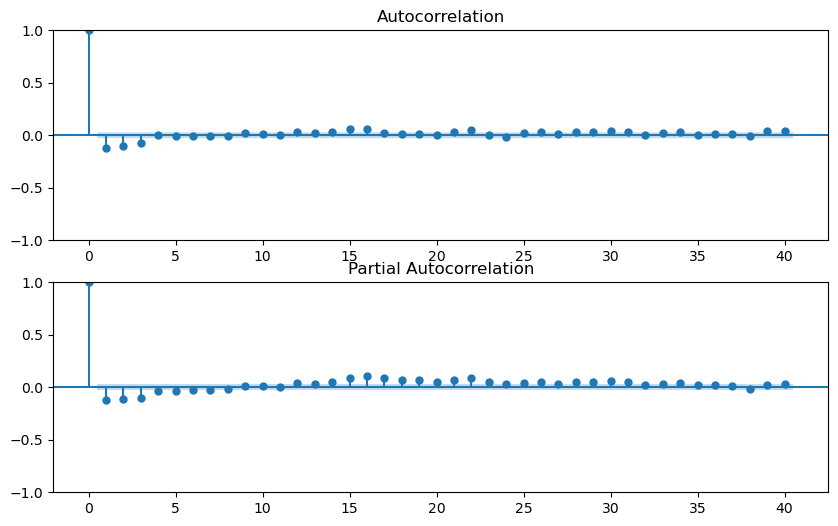

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, f

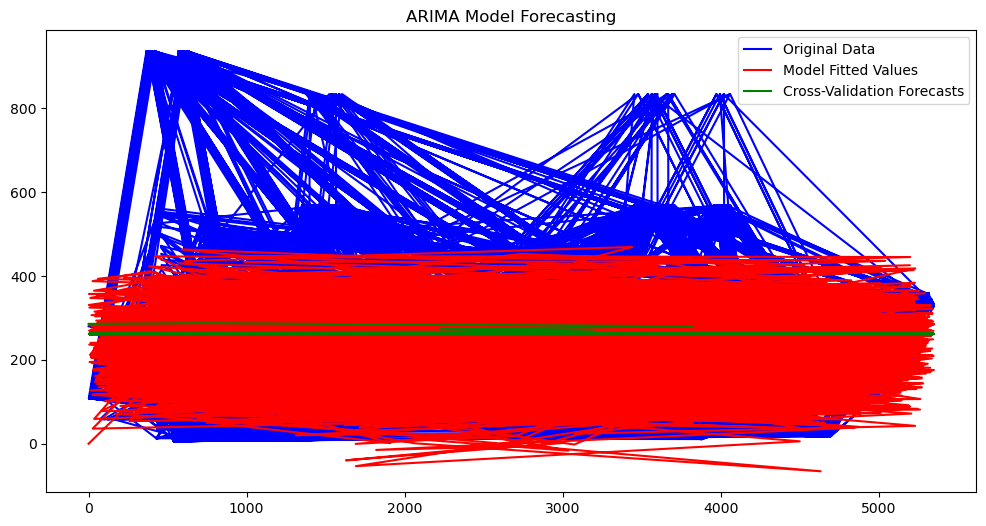

In [41]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Replace 'df' with your existing DataFrame containing 'ds' and 'y' columns

# Plot ACF and PACF to analyze the data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
sm.graphics.tsa.plot_acf(df['y'], lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(df['y'], lags=40, ax=ax2)
plt.show()

# Based on the ACF and PACF plots, determine the order (p, d, q) values that make sense
# For example, let's say you observe a significant lag at p=4 and d=1 based on the plots

# Create a list of candidate ARIMA models to try
p_values = [4]  # Replace with the value from ACF
d_values = [1]  # Replace with the value from PACF
q_values = range(0, 5)  # A range of possible q values to try

best_aic = float('inf')
best_order = None

# Try different combinations of p, d, and q and select the best model based on AIC
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                model = sm.tsa.ARIMA(df['y'], order=order)
                results = model.fit()
                aic = results.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = order
            except:
                continue

# Fit the best ARIMA model
best_model = sm.tsa.ARIMA(df['y'], order=best_order)
best_results = best_model.fit()

# Perform cross-validation to evaluate the model's forecasting performance
# (You can use different cross-validation methods)
cv_results = sm.tsa.ARIMA(df['y'], order=best_order).fit().forecast(steps=len(df), alpha=0.05)

# Plot your original data and the model's forecasts
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Original Data', color='blue')
plt.plot(df.index, best_results.fittedvalues, label='Model Fitted Values', color='red')
plt.plot(df.index, cv_results, label='Cross-Validation Forecasts', color='green')
plt.legend(loc='best')
plt.title('ARIMA Model Forecasting')
plt.show()


In [42]:
print("Best ARIMA Parameters (p, d, q):", best_order)

Best ARIMA Parameters (p, d, q): (4, 1, 3)
